In [335]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Read files

In [14]:
train_dataset_labels = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

# Prepare datasets

In [438]:
train_dataset = train_dataset_labels.dropna()
train_labels = train_dataset['Transported']

train_dataset["FamilyID"] = train_dataset["PassengerId"].str[:4].astype("int")
train_dataset["FamilySize"] = train_dataset.join(train_dataset.groupby("FamilyID").count()["PassengerId"]
                                                , on="FamilyID"
                                                , how="left"
                                                , rsuffix='_r'
                                                )["PassengerId_r"]
train_dataset["HomePlanet"] = train_dataset["HomePlanet"].astype('category')
train_dataset["HomePlanetID"] = train_dataset["HomePlanet"].cat.codes
train_dataset["CryoSleep"] = train_dataset["CryoSleep"].astype("boolean")
train_dataset["VIP"] = train_dataset["VIP"].astype("boolean")
train_dataset["Destination"] = train_dataset["Destination"].astype('category')
train_dataset["DestinationID"] = train_dataset["Destination"].cat.codes
train_dataset["Cabin_group"] = train_dataset["Cabin"].str[0]
train_dataset["Cabin_group"] = train_dataset["Cabin_group"].astype('category')
train_dataset["Cabin_group_ID"] = train_dataset["Cabin_group"].cat.codes
train_dataset["Cabin_type"] = train_dataset["Cabin"].str[-1]
train_dataset["Cabin_type"] = train_dataset["Cabin_type"].astype('category')
train_dataset["Cabin_type_ID"] = train_dataset["Cabin_type"].cat.codes

C:\Users\hp\AppData\Local\Temp\ipykernel_23468\875652099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["FamilyID"] = train_dataset["PassengerId"].str[:4].astype("int")
C:\Users\hp\AppData\Local\Temp\ipykernel_23468\875652099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["FamilySize"] = train_dataset.join(train_dataset.groupby("FamilyID").count()["PassengerId"]
C:\Users\hp\AppData\Local\Temp\ipykernel_23468\875652099.py:10: SettingWithCopyWarning: 
A value is trying to

In [440]:
training_set = train_dataset[["CryoSleep", "Age", "VIP", "RoomService", 
                              "FoodCourt", "ShoppingMall", "Spa", "VRDeck", 
                             "FamilyID", "FamilySize", "HomePlanetID", 
                              "DestinationID", "Cabin_group_ID", "Cabin_type_ID"]].fillna(False)

In [447]:
val_indices = training_set.sample(n=2000).index
not_val_mask = ~np.isin(training_set.index, val_indices)
val_mask = np.isin(training_set.index, val_indices)

# Exploration

In [348]:
true_indices = train_labels
false_indices = train_labels == False

In [384]:
enumerate(training_set.columns)

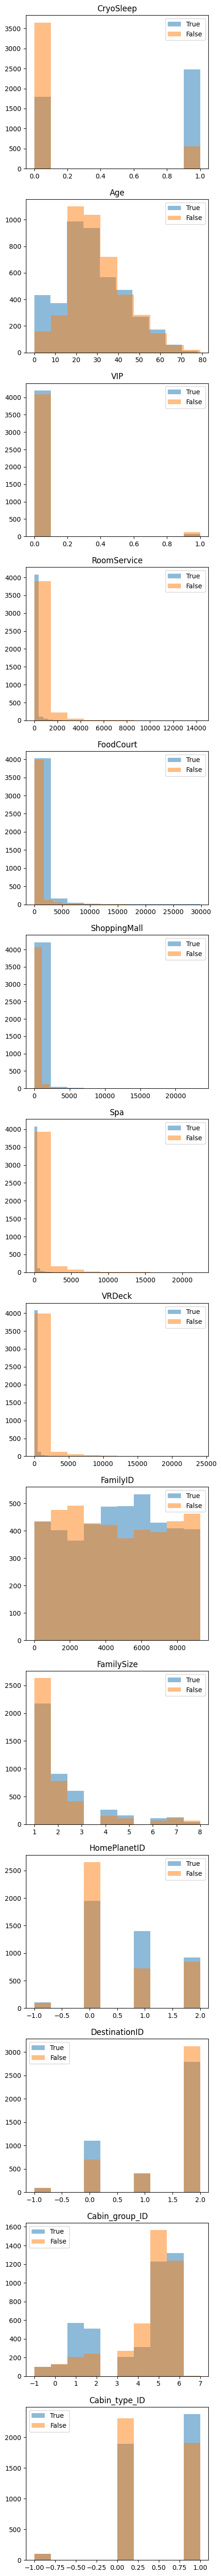

In [391]:
fig, ax = plt.subplots(training_set.shape[1], figsize=(5, training_set.shape[1]*5))

for row, name in enumerate(training_set.columns):
    
    plt.subplot(training_set.shape[1], 1, row+1)
    plt.title(name)
    ax[row].hist(train_dataset[true_indices][name].astype("float"), alpha=0.5, label="True")
    ax[row].hist(train_dataset[false_indices][name].astype("float"), alpha=0.5, label="False")
    plt.legend()

In [392]:
filter_columns = ["CryoSleep",
                 "Age", 
                 "FamilySize",
                 "HomePlanetID", 
                 "DestinationID", 
                 "Cabin_group_ID", 
                 "Cabin_type_ID"]

# Prepare submission

In [181]:
test_dataset = pd.read_csv("test.csv")

test_dataset["FamilyID"] = test_dataset["PassengerId"].str[:4].astype("int")
test_dataset["FamilySize"] = test_dataset.join(test_dataset.groupby("FamilyID").count()["PassengerId"]
                                                , on="FamilyID"
                                                , how="left"
                                                , rsuffix='_r'
                                                )["PassengerId_r"]

HP_cats = train_dataset.groupby(["HomePlanet","HomePlanetID"]).count()
HP_cats = HP_cats[HP_cats["PassengerId"] > 0]["PassengerId"]
HP_cats = HP_cats.reset_index().set_index("HomePlanet")
test_dataset["HomePlanet"] = test_dataset["HomePlanet"].astype('category')
test_dataset["HomePlanetID"] = test_dataset.join(HP_cats
                                                , on="HomePlanet"
                                                , how="left"
                                                , rsuffix='_r'
                                                )["HomePlanetID"]
test_dataset["CryoSleep"] = test_dataset["CryoSleep"].astype("boolean")
test_dataset["VIP"] = test_dataset["VIP"].astype("boolean")

DST_cats = train_dataset.groupby(["Destination","DestinationID"]).count()
DST_cats = DST_cats[DST_cats["PassengerId"] > 0]["PassengerId"]
DST_cats = DST_cats.reset_index().set_index("Destination")
test_dataset["Destination"] = train_dataset["Destination"].astype('category')
test_dataset["DestinationID"] = test_dataset.join(DST_cats
                                                , on="Destination"
                                                , how="left"
                                                , rsuffix='_r'
                                                )["DestinationID"]

CG_cats = train_dataset.groupby(["Cabin_group","Cabin_group_ID"]).count()
CG_cats = CG_cats[CG_cats["PassengerId"] > 0]["PassengerId"]
CG_cats = CG_cats.reset_index().set_index("Cabin_group")
test_dataset["Cabin_group"] = train_dataset["Cabin"].str[0]
test_dataset["Cabin_group"] = train_dataset["Cabin_group"].astype('category')
test_dataset["Cabin_group_ID"] = test_dataset.join(CG_cats
                                                , on="Cabin_group"
                                                , how="left"
                                                , rsuffix='_r'
                                                )["Cabin_group_ID"]

CT_cats = train_dataset.groupby(["Cabin_type","Cabin_type_ID"]).count()
CT_cats = CT_cats[CT_cats["PassengerId"] > 0]["PassengerId"]
CT_cats = CT_cats.reset_index().set_index("Cabin_type")
test_dataset["Cabin_type"] = train_dataset["Cabin"].str[-1]
test_dataset["Cabin_type"] = train_dataset["Cabin_type"].astype('category')
test_dataset["Cabin_type_ID"] = test_dataset.join(CT_cats
                                                , on="Cabin_type"
                                                , how="left"
                                                , rsuffix='_r'
                                                )["Cabin_type_ID"]

In [182]:
testing_set = test_dataset[["CryoSleep", "Age", "VIP", "RoomService", 
                              "FoodCourt", "ShoppingMall", "Spa", "VRDeck", 
                             "FamilyID", "FamilySize", "HomePlanetID", 
                              "DestinationID", "Cabin_group_ID", "Cabin_type_ID"]].fillna(False)

# DecisionTree

In [448]:
dtc = DecisionTreeClassifier(max_depth = 50)
dtc.fit(training_set[not_val_mask], train_labels[not_val_mask])

DecisionTreeClassifier(max_depth=50)

In [449]:
('train' , dtc.score(training_set[not_val_mask], train_labels[not_val_mask])
, 'val' , dtc.score(training_set[val_mask], train_labels[val_mask]))

('train', 0.9997828918801563, 'val', 0.741)

In [450]:
f1_score(dtc.predict(training_set[val_mask]), train_labels[val_mask])

0.74203187250996

In [190]:
dts_result = test_dataset[["PassengerId"]]
dts_result["Transported"] = dtc.predict(testing_set)
dts_result.to_csv("DTS_result.csv", index=False)

C:\Users\hp\AppData\Local\Temp\ipykernel_23468\1544376646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dts_result["Transported"] = dtc.predict(testing_set)


# Random forest

In [332]:
rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(training_set[not_val_mask], train_labels[not_val_mask])

RandomForestClassifier(n_estimators=50)

In [333]:
('train' , rfc.score(training_set[not_val_mask], train_labels[not_val_mask])
, 'val' , rfc.score(training_set[val_mask], train_labels[val_mask])
, 'xF1', f1_score(rfc.predict(training_set[val_mask]), train_labels[val_mask]))

('train', 0.9998505901688332, 'val', 0.7925, 'xF1', 0.7821522309711286)

In [334]:
rfc_result = test_dataset[["PassengerId"]]
rfc_result["Transported"] = rfc.predict(testing_set)
rfc_result.to_csv("RFC_result.csv", index=False)

C:\Users\hp\AppData\Local\Temp\ipykernel_23468\2173469091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfc_result["Transported"] = rfc.predict(testing_set)


# AdaBoost

In [451]:
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(training_set[not_val_mask], train_labels[not_val_mask])

AdaBoostClassifier(n_estimators=100)

In [452]:
('train' , abc.score(training_set[not_val_mask], train_labels[not_val_mask])
, 'val' , abc.score(training_set[val_mask], train_labels[val_mask])
, 'F1', f1_score(abc.predict(training_set[val_mask]), train_labels[val_mask]))

('train', 0.816977854971776, 'val', 0.778, 'F1', 0.782991202346041)

# NN

In [412]:
len(filter_columns), training_set.shape

(7, (8693, 14))

In [453]:
inputs = tf.keras.Input(shape=(14))
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(inputs)

NN_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Titanic')
NN_model.summary()

Model: "Titanic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 14)]              0         
                                                                 
 dense_20 (Dense)            (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [454]:
NN_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.Accuracy()],
)

In [455]:
training_set_normalized = (training_set.astype("float")-training_set.astype("float").mean())/training_set.astype("float").std()
#training_set_normalized = training_set_normalized[filter_columns]

In [456]:
NN_model.fit(training_set_normalized[not_val_mask].to_numpy().astype("float")
          , train_labels[not_val_mask].to_numpy().astype("int")
          , batch_size=32
          , epochs=100
          , validation_data = (training_set_normalized[val_mask].to_numpy().astype("float")
                              , train_labels[val_mask].to_numpy().astype("int"))
         )

Epoch 1/100
144/144 [==============================] - 1s 3ms/step - loss: 0.8163 - accuracy: 0.0000e+00 - val_loss: 0.7220 - val_accuracy: 0.0000e+00
Epoch 2/100
144/144 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.0000e+00 - val_loss: 0.6286 - val_accuracy: 0.0000e+00
Epoch 3/100
144/144 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.0000e+00 - val_loss: 0.5734 - val_accuracy: 0.0000e+00
Epoch 4/100
144/144 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.0000e+00 - val_loss: 0.5405 - val_accuracy: 0.0000e+00
Epoch 5/100
144/144 [==============================] - 0s 2ms/step - loss: 0.5324 - accuracy: 0.0000e+00 - val_loss: 0.5206 - val_accuracy: 0.0000e+00
Epoch 6/100
144/144 [==============================] - 0s 2ms/step - loss: 0.5136 - accuracy: 0.0000e+00 - val_loss: 0.5075 - val_accuracy: 0.0000e+00
Epoch 7/100
144/144 [==============================] - 0s 2ms/step - loss: 0.5011 - accuracy: 

Epoch 55/100
144/144 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.0000e+00 - val_loss: 0.4449 - val_accuracy: 0.0000e+00
Epoch 56/100
144/144 [==============================] - 0s 1ms/step - loss: 0.4396 - accuracy: 0.0000e+00 - val_loss: 0.4445 - val_accuracy: 0.0000e+00
Epoch 57/100
144/144 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.0000e+00 - val_loss: 0.4443 - val_accuracy: 0.0000e+00
Epoch 58/100
144/144 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.0000e+00 - val_loss: 0.4444 - val_accuracy: 0.0000e+00
Epoch 59/100
144/144 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.0000e+00 - val_loss: 0.4445 - val_accuracy: 0.0000e+00
Epoch 60/100
144/144 [==============================] - 0s 1ms/step - loss: 0.4394 - accuracy: 0.0000e+00 - val_loss: 0.4442 - val_accuracy: 0.0000e+00
Epoch 61/100
144/144 [==============================] - 0s 2ms/step - loss: 0.4394 - acc

In [457]:
NN_model.predict(training_set_normalized[val_mask].to_numpy().astype("float"))

63/63 [==============================] - 0s 827us/step


array([[0.21626493],
       [0.03025674],
       [0.99436414],
       ...,
       [0.8438583 ],
       [0.70197165],
       [0.0158614 ]], dtype=float32)

In [458]:
tau = 0.45
def check_res(x, tau):
    if x>=tau:
        return 1
    else:
        return 0

NN_res = np.vectorize(check_res)(NN_model.predict(training_set_normalized[val_mask].to_numpy().astype("float")), tau)

('train' , NN_model.evaluate(training_set_normalized[not_val_mask].to_numpy().astype("float"), train_labels[not_val_mask])
, 'val' , NN_model.evaluate(training_set_normalized[val_mask].to_numpy().astype("float"), train_labels[val_mask])
, 'F1' , f1_score(train_labels[val_mask].to_numpy().astype("int"), NN_res))

63/63 [==============================] - 0s 1ms/step - loss: 0.4427 - accuracy: 5.0000e-04


('train',
 [0.4385635256767273, 0.0],
 'val',
 [0.44273775815963745, 0.0005000000237487257],
 'F1',
 0.7984790874524714)

In [295]:
testing_set_normalized = (testing_set.astype("float")-training_set.astype("float").mean())/training_set.astype("float").std()

nnd_result = test_dataset[["PassengerId"]]
nnd_result["Transported"] = np.vectorize(check_res)(NN_model.predict(testing_set_normalized.to_numpy().astype("float"))
                                                    , tau).astype("bool")
nnd_result.to_csv("NN_dense_result.csv", index=False)
nnd_result


134/134 [==============================] - 0s 902us/step


C:\Users\hp\AppData\Local\Temp\ipykernel_23468\1210230977.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnd_result["Transported"] = np.vectorize(check_res)(NN_model.predict(testing_set_normalized.to_numpy().astype("float"))


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


# OLS

In [459]:
X = training_set_normalized[not_val_mask].to_numpy().astype("float")
Y = train_labels[not_val_mask].astype("float")
X.shape, Y.shape

((4606, 14), (4606,))

In [460]:
W_ols = np.linalg.inv(X.T @ X)@X.T@Y

In [461]:
tau = 0.03
def check_res(x, tau):
    if x>=tau:
        return 1
    else:
        return 0

NN_res = np.vectorize(check_res)(training_set_normalized[val_mask].to_numpy().astype("float") @ W_ols, tau)

('train' , accuracy_score(train_labels[not_val_mask].to_numpy().astype("int"), np.vectorize(check_res)(training_set_normalized[not_val_mask].to_numpy().astype("float") @ W_ols, tau))
, 'val' , accuracy_score(train_labels[val_mask].to_numpy().astype("int"), NN_res)
, 'F1' , f1_score(train_labels[val_mask].to_numpy().astype("int"), NN_res))

('train', 0.7635692574902301, 'val', 0.768, 'F1', 0.7458926615553121)

In [462]:
testing_set_normalized = (testing_set.astype("float")-training_set.astype("float").mean())/training_set.astype("float").std()

nnd_result = test_dataset[["PassengerId"]]
nnd_result["Transported"] = np.vectorize(check_res)(testing_set_normalized.to_numpy().astype("float") @ W_ols
                                                    , tau).astype("bool")
nnd_result.to_csv("OLS_result.csv", index=False)
nnd_result

C:\Users\hp\AppData\Local\Temp\ipykernel_23468\1206829145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnd_result["Transported"] = np.vectorize(check_res)(testing_set_normalized.to_numpy().astype("float") @ W_ols


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
